Let's use a U-NET architecture for his image segmentation project. The architecture is as follows, although I will be using 128x128 images:
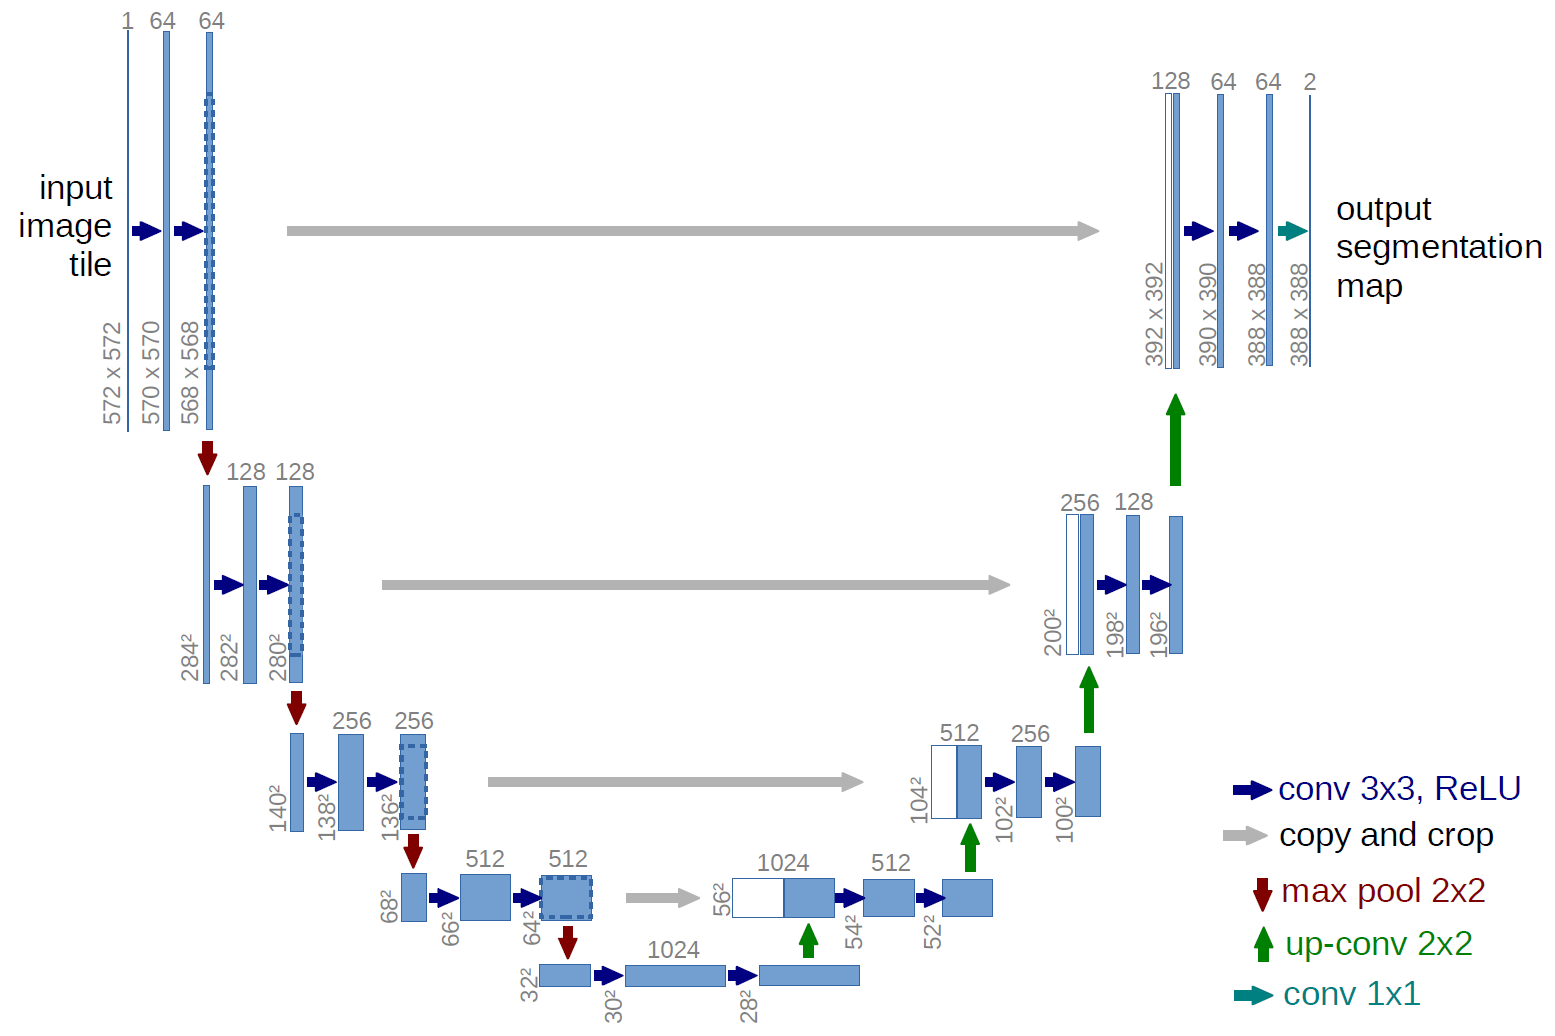

In [15]:
import tensorflow as tf


In [24]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# The Data

In [116]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import pydicom
import random

In [75]:
TRAIN_PATH = '/Users/lesleypotters/data_science/nuclei data/data-science-bowl-2018/stage1_train/'
TEST_PATH = '/Users/lesleypotters/data_science/nuclei data/data-science-bowl-2018/stage1_test/'

In [102]:
#get the ids of all images (=folder names), so run through all folder
#names and save them in a list
try:
    train_ids = next(os.walk('/Users/lesleypotters/data_science/nuclei data/data-science-bowl-2018/stage1_train/'))[1]
except StopIteration:
    pass

try:
    test_ids = next(os.walk('/Users/lesleypotters/data_science/nuclei data/data-science-bowl-2018/stage1_test/'))[1]
except StopIteration:
    pass

In [103]:
len(train_ids), len(test_ids)

(670, 65)

In [91]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [92]:
TRAIN_PATH = 'data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data-science-bowl-2018/stage1_test/'

In [98]:
#create all training data and the masks (with True / False 1/0) in the right size
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_ #this defines the path for each image
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] #this reads in the image (*.png)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #resize the image
    X_train[n] = img #fill the image data into the array of zeros (could also have used .append)
    
    #for the mask file, the same, but mask are many seperate files with each one cell, so only keep the max values 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool) 
    for mask_file in next(os.walk(path + '/masks/'))[2]: #in each subfolder
        mask_ = imread(path + '/masks/' + mask_file) #get each image
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', #save the os and 1s
                                     preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_) #keep the maximum of the zeros and actual values (1 if there is a cell)
    Y_train[n] = mask

  0%|                                                                                   | 0/670 [00:00<?, ?it/s]/var/folders/_m/cq3r85ys541d12f3j4rnvfs80000gn/T/ipykernel_15288/920233550.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|█████████████████████████████████████████████████████████████████████████| 670/670 [03:19<00:00,  3.35it/s]


In [109]:
#create all TESTING data and the masks (with True / False 1/0) in the right size
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_ #this defines the path to get the images
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] #this reads in the image (*.png)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #resize the image
    X_test[n] = img #fill the image data into the array of zeros (could also have used .append)
    
    

100%|███████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 61.78it/s]


# Visualize

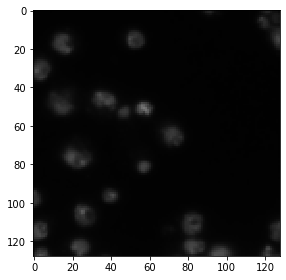

In [119]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()

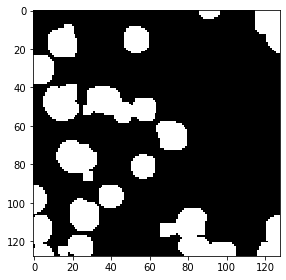

In [120]:
imshow(np.squeeze(Y_train[image_x]))
plt.show()

# Define the model

In [110]:
#prepare input to float32
tf.keras.layers.Lambda(lambda x: x / 255)

In [111]:
#Build the U-shaped model

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

#prepare input to float32
tf.keras.layers.Lambda(lambda x: x / 255)

##Contracting path
#Layer 1
Conv2D_1_a = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
dropout1 = tf.keras.layers.Dropout(0.1)(Conv2D_1_a)
Conv2D_1_b = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout1)
maxpool1 = tf.keras.layers.MaxPooling2D((2,2))(Conv2D_1_b)

#Layer 2
Conv2D_2_a = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(maxpool1)
dropout2 = tf.keras.layers.Dropout(0.1)(Conv2D_2_a)
Conv2D_2_b = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout2)
maxpool2 = tf.keras.layers.MaxPooling2D((2,2))(Conv2D_2_b)

#Layer 3
Conv2D_3_a = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(maxpool2)
dropout3 = tf.keras.layers.Dropout(0.1)(Conv2D_3_a)
Conv2D_3_b = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout3)
maxpool3 = tf.keras.layers.MaxPooling2D((2,2))(Conv2D_3_b)

#Layer 4
Conv2D_4_a = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(maxpool3)
dropout4 = tf.keras.layers.Dropout(0.1)(Conv2D_4_a)
Conv2D_4_b = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout4)
maxpool4 = tf.keras.layers.MaxPooling2D((2,2))(Conv2D_4_b)

#Layer 5
Conv2D_5_a = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(maxpool4)
dropout5 = tf.keras.layers.Dropout(0.1)(Conv2D_5_a)
Conv2D_5_b = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout5)

##Expensive path
#Layer 6
Conv2D_trans_1 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(Conv2D_5_b)
conc1 = tf.keras.layers.concatenate([Conv2D_4_b,Conv2D_trans_1])
Conv2D_6_a = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conc1)
dropout6 = tf.keras.layers.Dropout(0.1)(Conv2D_6_a)
Conv2D_6_b = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout6)

#Layer 7
Conv2D_trans_2 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(Conv2D_6_b)
conc2 = tf.keras.layers.concatenate([Conv2D_3_b,Conv2D_trans_2])
Conv2D_7_a = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conc2)
dropout7 = tf.keras.layers.Dropout(0.1)(Conv2D_7_a)
Conv2D_7_b = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout7)

#Layer 8
Conv2D_trans_3 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(Conv2D_7_b)
conc3 = tf.keras.layers.concatenate([Conv2D_2_b,Conv2D_trans_3])
Conv2D_8_a = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conc3)
dropout8 = tf.keras.layers.Dropout(0.1)(Conv2D_8_a)
Conv2D_8_b = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout8)

#Layer 9
Conv2D_trans_4 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(Conv2D_8_b)
conc4 = tf.keras.layers.concatenate([Conv2D_1_b,Conv2D_trans_4])
Conv2D_9_a = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conc4)
dropout9 = tf.keras.layers.Dropout(0.1)(Conv2D_9_a)
Conv2D_9_b = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout9)

outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(Conv2D_9_b)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 128, 128, 16) 448         input_11[0][0]                   
__________________________________________________________________________________________________
dropout_71 (Dropout)            (None, 128, 128, 16) 0           conv2d_149[0][0]                 
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 128, 128, 16) 2320        dropout_71[0][0]                 
____________________________________________________________________________________________

In [112]:
# create model checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint('model for nuclei.h5', 
                                                verbose=1, 
                                                save_best_only=True)

In [125]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'), 
    checkpoint
]

2022-04-10 22:29:27.841690: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-10 22:29:27.841739: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-10 22:29:27.842159: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [126]:
results = model.fit(X_train,Y_train, 
                    batch_size=25, 
                    epochs=100,
                    callbacks=callbacks,
                    validation_split=0.1)

Epoch 1/100
 3/25 [==>...........................] - ETA: 2s - loss: 0.0682 - accuracy: 0.9719

2022-04-10 22:29:29.119642: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-10 22:29:29.119654: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-10 22:29:29.222391: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-10 22:29:29.222907: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-10 22:29:29.223600: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_10_22_29_29
2022-04-10 22:29:29.224170: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_10_22_29_29/Lesleys-MPB.local.trace.json.gz
2022-04-10 22:29:29.224800: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_10_22_29_29
2022-04-10 22:29:29.224989

25/25 [==============================] - 2s 97ms/step - loss: 0.0808 - accuracy: 0.9679 - val_loss: 0.0849 - val_accuracy: 0.9684

Epoch 00001: val_loss did not improve from 0.08243
Epoch 2/100
25/25 [==============================] - 2s 96ms/step - loss: 0.0784 - accuracy: 0.9685 - val_loss: 0.0853 - val_accuracy: 0.9689

Epoch 00002: val_loss did not improve from 0.08243
Epoch 3/100
25/25 [==============================] - 2s 95ms/step - loss: 0.0770 - accuracy: 0.9691 - val_loss: 0.0838 - val_accuracy: 0.9693

Epoch 00003: val_loss did not improve from 0.08243
Epoch 4/100
25/25 [==============================] - 2s 96ms/step - loss: 0.0757 - accuracy: 0.9694 - val_loss: 0.0857 - val_accuracy: 0.9688

Epoch 00004: val_loss did not improve from 0.08243
Epoch 5/100
25/25 [==============================] - 2s 96ms/step - loss: 0.0746 - accuracy: 0.9700 - val_loss: 0.0859 - val_accuracy: 0.9675

Epoch 00005: val_loss did not improve from 0.08243
Epoch 6/100
25/25 [=======================

# Check the model

In [129]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

3/3 [==============================] - 0s 220ms/step


In [130]:
#when the prediction is greater than 0.5, we assign a 1
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

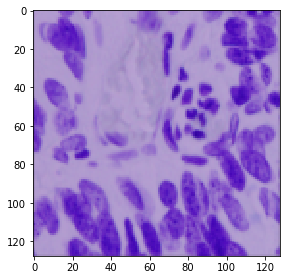

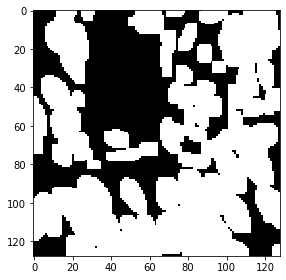

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


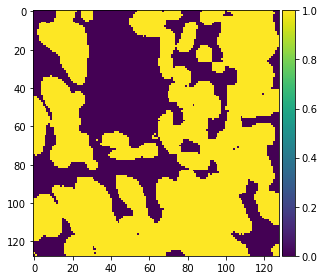

In [131]:
idx = random.randint(0, len(train_ids))
imshow(X_train[idx])
plt.show()
imshow(np.squeeze(Y_train[idx]))
plt.show()
imshow(np.squeeze(preds_train_t[idx]))
plt.show()

# Tensorboard visualization

In [136]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [137]:
%tensorboard --logdir logs/fit